In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import pickle

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork

def plot_overview(plot_functions, n_rows=2, n_cols=2, size_factor=1.):
    plt.figure(1, figsize=(5 * n_cols * size_factor, 3.5 * n_rows * size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        pf()
        #plt.legend(loc="best")
        idx += 1

    # plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)
    plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

def plot_cv_results2(cv_result):
    alphas = np.logspace(-5., 0., num=20)
    l1_ratios = np.linspace(0., 1., num=6)
    l1_dict = ana.cluster_along_arg(cv_result, "l1_ratio", l1_ratios)
    alphas_dict = {}
    for l1_ratio in l1_dict.keys():
        alphas_dict[l1_ratio] = ana.cluster_along_arg(l1_dict[l1_ratio], "alpha", alphas)
        
    for l1_ratio in l1_dict.keys():
        scores_mean = []
        scores_err = []
        for alpha in alphas:
            cv_data = alphas_dict[l1_ratio][alpha]
            scores = []
            for d in cv_data:
                scores.append(d['scores'][0])
            scores = np.array(scores)
            scores_mean.append(np.mean(scores))
            scores_err.append(np.std(scores))
        scores_mean = np.array(scores_mean)
        scores_err = np.array(scores_err)
        #print(scores_mean)
        #plt.errorbar(alphas, -scores_mean, yerr=scores_err, label='score l1={}'.format(l1_ratio))
        plt.plot(alphas, -scores_mean, label='score l1={}'.format(l1_ratio))
    
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    #plt.legend()

/home/chris/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
data_dir = "./results/"

In [26]:
est_rates_files =  {
    1: "est_rates_for_1.npy",
    2: "est_rates_for_2.npy",
    3: "est_rates_for_3.npy",
    4: "est_rates_for_4.npy",
    5: "est_rates_for_5.npy",
    6: "est_rates_for_6.npy",
    7: "est_rates_for_7.npy",
    8: "est_rates_for_8.npy",
    9: "est_rates_for_9.npy",
    10: "est_rates_for_10.npy",
}

In [27]:
lsq_rates_files =  {
    1: "lsq_rates_for_1.npy",
    2: "lsq_rates_for_2.npy",
    3: "lsq_rates_for_3.npy",
    4: "lsq_rates_for_4.npy",
    5: "lsq_rates_for_5.npy",
    6: "lsq_rates_for_6.npy",
    7: "lsq_rates_for_7.npy",
    8: "lsq_rates_for_8.npy",
    9: "lsq_rates_for_9.npy",
    10: "lsq_rates_for_10.npy",
}

In [28]:
cv_results_files = {
    1: "cv_results_for_1.pickle",
    2: "cv_results_for_2.pickle",
    3: "cv_results_for_3.pickle",
    4: "cv_results_for_4.pickle",
    5: "cv_results_for_5.pickle",
    6: "cv_results_for_6.pickle",
    7: "cv_results_for_7.pickle",
    8: "cv_results_for_8.pickle",
    9: "cv_results_for_9.pickle",
    10: "cv_results_for_10.pickle",
}

In [29]:
regulation_network = RegulationNetwork()
desired_rates = regulation_network.desired_rates

## Badness as function n_realisations

In [30]:
est_rates = dict()
for n, filename in est_rates_files.items():
    path = os.path.join(data_dir, filename)
    est_rates[n] = np.load(path)

In [31]:
lsq_rates = dict()
for n, filename in lsq_rates_files.items():
    path = os.path.join(data_dir, filename)
    lsq_rates[n] = np.load(path)

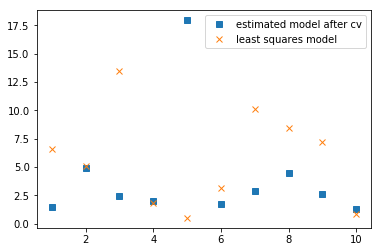

In [36]:
n_realisations = []
badness_est = []
badness_lsq = []
goodnesses_est = []
goodnesses_lsq = []
indices_of_wrong_reactions = np.array(
    [12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], dtype=int
)

def guete(desired_rates, rates):
    result = 0
    for i in range(len(desired_rates)):
        if (rates[i] > 0. and desired_rates[i] > 0.): 
            result += 1
        elif (rates[i]==0. and desired_rates[i] > 0.):
            pass
        elif (rates[i] > 0. and desired_rates[i]==0.):
            result -= 1
    return result

def error_function(desired_rates, rates):
    return np.sum(np.absolute((rates - desired_rates)*(rates - desired_rates)))

for n, rates in est_rates.items():
    n_realisations.append(n)
    cutoff_rates = np.array([r if r>1e-4 else 0. for r in rates])
    goodnesses_est.append(error_function(desired_rates, cutoff_rates))
    #goodnesses_est.append(sum([1 if r > 0. else 0. for r in cutoff_rates]))
    #norm_est = np.sum(np.absolute(rates[indices_of_wrong_reactions] - desired_rates[indices_of_wrong_reactions]))
    #norm_est = np.sum(np.absolute(rates - desired_rates))
    #badness_est.append(norm_est)
    
    lsq_rate = lsq_rates[n]
    cutoff_lsq_rates = np.array([r if r>1e-4 else 0. for r in lsq_rate])
    #goodnesses_lsq.append(sum([1 if r > 0. else 0. for r in cutoff_lsq_rates]))
    goodnesses_lsq.append(error_function(desired_rates, cutoff_lsq_rates))
    #norm_lsq = np.sum(np.absolute(lsq_rate[indices_of_wrong_reactions] - desired_rates[indices_of_wrong_reactions]))
    #norm_lsq = np.sum(np.absolute(lsq_rate - desired_rates))
    #badness_lsq.append(norm_lsq)

n_realisations = np.array(n_realisations)
#badness_est = np.array(badness_est)
#badness_lsq = np.array(badness_lsq)
goodnesses_est = np.array(goodnesses_est)
goodnesses_lsq = np.array(goodnesses_lsq)
#plt.plot(n_realisations, badness_est, label="estimated model after cv")
#plt.plot(n_realisations, badness_lsq, label="least squares model")
plt.plot(n_realisations, goodnesses_est, "s", label="estimated model after cv")
plt.plot(n_realisations, goodnesses_lsq, "x", label="least squares model")

#nonoise_badness = np.sum(np.absolute(rates_nonoise - desired_rates))
#plt.plot([1.,100.], [nonoise_badness, nonoise_badness], "k--", label="No noise")

plt.legend(loc="best")
#plt.xlabel("number of realisations to average")
#plt.title("Badness of estimating the generating model")
#plt.title("Goodness in recovering the reference model")
#plt.ylabel(r"$\|\xi_\mathrm{est} - \xi_\mathrm{exp}\|_1$")
#plt.ylabel(r"number of correctly identified reactions")
#plt.xscale("log")
plt.show()

In [13]:
est_rates.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
result_chart = np.zeros((len(est_rates), len(est_rates[1])))
reference_pattern = np.array([[1. if d > 0. else 0. for d in desired_rates]])

cutoff = 1e-1

all_patterns_est = []
for n, rates in est_rates.items():
    current_pattern = []
    for i in range(len(rates)):
        distance_to_desired = abs(desired_rates[i] - rates[i])
        current_pattern.append(distance_to_desired)
    current_pattern = np.array(current_pattern)
    all_patterns_est.append(current_pattern)
all_patterns_est = np.array(all_patterns_est)

all_patterns_lsq = []
for n, rates in lsq_rates.items():
    current_pattern = []
    for i in range(len(rates)):
        distance_to_desired = abs(desired_rates[i] - rates[i])
        current_pattern.append(distance_to_desired)
    current_pattern = np.array(current_pattern)
    all_patterns_lsq.append(current_pattern)
all_patterns_lsq = np.array(all_patterns_lsq)

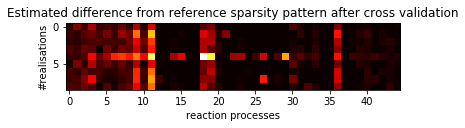

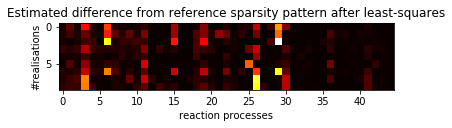

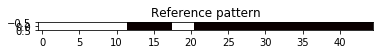

In [20]:
import matplotlib as mpl
plt.imshow(all_patterns_est, cmap="hot")
plt.title("Estimated difference from reference sparsity pattern after cross validation")
plt.ylabel("#realisations")
plt.xlabel("reaction processes")
plt.show()

plt.title("Estimated difference from reference sparsity pattern after least-squares")
plt.imshow(all_patterns_lsq, cmap="hot")
plt.ylabel("#realisations")
plt.xlabel("reaction processes")
plt.show()

plt.imshow(reference_pattern, cmap="hot")
plt.title("Reference pattern")
plt.show()

## Look at models in transition regime

Text(0.5,1,'n_realisations = 10')

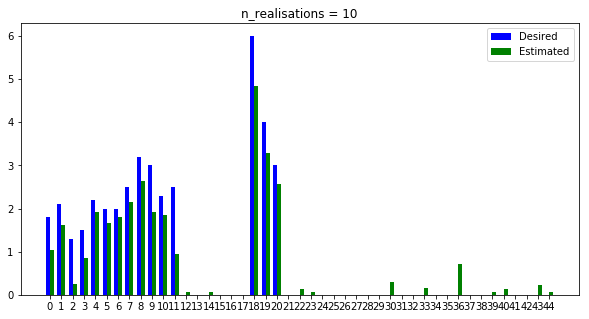

In [216]:
ana.plot_rates_bar(desired_rates, est_rates[10])
plt.title("n_realisations = "+str(10))

Text(0.5,1,'n_realisations = 10')

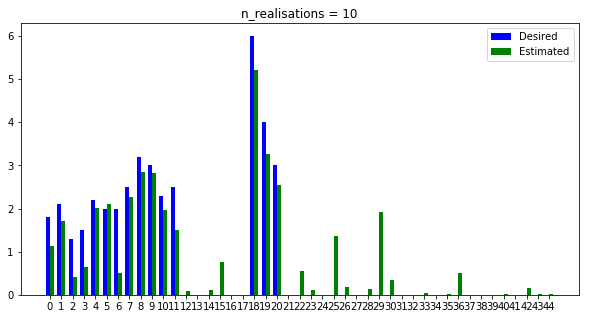

In [217]:
ana.plot_rates_bar(desired_rates, lsq_rates[10])
plt.title("n_realisations = "+str(10))

In [107]:
est_rates[1000]

array([1.77482883e+00, 2.10012675e+00, 1.25755024e+00, 1.26991676e+00,
       2.24448803e+00, 2.02230732e+00, 1.98550789e+00, 2.35127189e+00,
       3.30001317e+00, 2.84020708e+00, 2.27862980e+00, 1.93491090e+00,
       0.00000000e+00, 5.98323120e-02, 1.55136819e-02, 2.77005552e-02,
       9.34506011e-02, 0.00000000e+00, 6.20514785e+00, 4.08270781e+00,
       2.99500108e+00, 1.86531947e-02, 1.69298752e-01, 1.55136819e-02,
       7.76824413e-02, 5.86145939e-01, 2.68941644e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.15355324e-02, 4.25171777e-18,
       0.00000000e+00, 3.40120518e-02, 0.00000000e+00, 0.00000000e+00,
       2.69927747e-01, 0.00000000e+00, 2.39760253e-02, 1.11766857e-02,
       2.84334211e-02, 6.08541776e-02, 7.82904735e-02, 0.00000000e+00,
       3.60746532e-03])

Text(0.5,1,'n_realisations = 50')

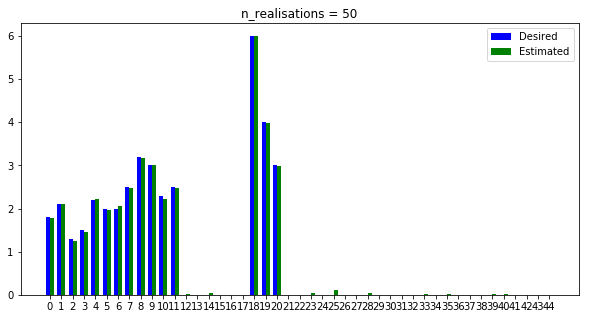

In [32]:
ana.plot_rates_bar(desired_rates, est_rates[50])
plt.title("n_realisations = "+str(50))

## Cross validation results

In [112]:
cv_results = dict()
for n, filename in cv_results_files.items():
    path = os.path.join(data_dir, filename)
    with open(path, "rb") as file:
        cv_results[n] = pickle.load(file)

In [113]:
cv_results

{0: [{'alpha': 1e-05,
   'l1_ratio': 0.4,
   'scores': [-65.88532412887014],
   'test_trajs': array([0]),
   'train_trajs': array([1])},
  {'alpha': 1e-05,
   'l1_ratio': 0.2,
   'scores': [-65.87889338231366],
   'test_trajs': array([0]),
   'train_trajs': array([1])},
  {'alpha': 1e-05,
   'l1_ratio': 0.6000000000000001,
   'scores': [-65.89167615273925],
   'test_trajs': array([0]),
   'train_trajs': array([1])},
  {'alpha': 1e-05,
   'l1_ratio': 0.0,
   'scores': [-65.88202874511107],
   'test_trajs': array([0]),
   'train_trajs': array([1])},
  {'alpha': 1e-05,
   'l1_ratio': 0.2,
   'scores': [-64.01893486025094],
   'test_trajs': array([1]),
   'train_trajs': array([0])},
  {'alpha': 1e-05,
   'l1_ratio': 0.4,
   'scores': [-64.0226210520899],
   'test_trajs': array([1]),
   'train_trajs': array([0])},
  {'alpha': 1e-05,
   'l1_ratio': 0.6000000000000001,
   'scores': [-64.0225772471114],
   'test_trajs': array([1]),
   'train_trajs': array([0])},
  {'alpha': 1e-05,
   'l1_ratio

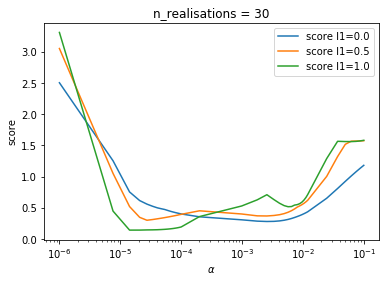

In [31]:
plot_cv(30)

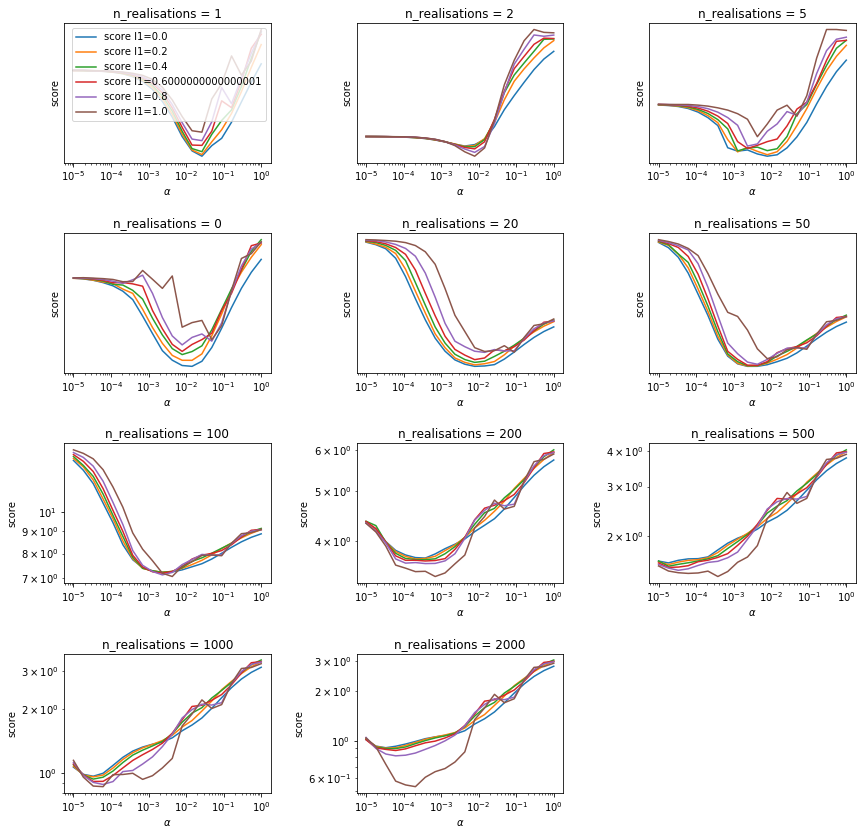

In [136]:
def plot_cv(n):
    plot_cv_results2(cv_results[n])
    plt.title("n_realisations = "+str(n))
    plt.xscale("log")
    if n==1:
        plt.legend(loc="best")

pfs = []
for n in cv_results.keys():
    pfs.append(
        lambda _n=n: plot_cv(_n)
    )

plot_overview(pfs, n_cols=3, n_rows=5, size_factor=0.8)